In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/brain-mri-images-for-brain-tumor-detection/yes/Y66.JPG
/kaggle/input/brain-mri-images-for-brain-tumor-detection/yes/Y187.jpg
/kaggle/input/brain-mri-images-for-brain-tumor-detection/yes/Y106.jpg
/kaggle/input/brain-mri-images-for-brain-tumor-detection/yes/Y161.JPG
/kaggle/input/brain-mri-images-for-brain-tumor-detection/yes/Y14.jpg
/kaggle/input/brain-mri-images-for-brain-tumor-detection/yes/Y22.jpg
/kaggle/input/brain-mri-images-for-brain-tumor-detection/yes/Y67.JPG
/kaggle/input/brain-mri-images-for-brain-tumor-detection/yes/Y148.JPG
/kaggle/input/brain-mri-images-for-brain-tumor-detection/yes/Y45.JPG
/kaggle/input/brain-mri-images-for-brain-tumor-detection/yes/Y111.JPG
/kaggle/input/brain-mri-images-for-brain-tumor-detection/yes/Y9.jpg
/kaggle/input/brain-mri-images-for-brain-tumor-detection/yes/Y185.jpg
/kaggle/input/brain-mri-images-for-brain-tumor-detection/yes/Y186.jpg
/kaggle/input/brain-mri-images-for-brain-tumor-detection/yes/Y58.JPG
/kaggle/input/brain-mri-imag

In [2]:
import tensorflow as tf
from urllib.request import urlretrieve
from os.path import isfile, isdir
#from tqdm import tqdm 
#import tarfile
import pickle
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.optimizers import Adam
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D
from keras.layers.advanced_activations import LeakyReLU 
from keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import OneHotEncoder,LabelEncoder
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.losses import binary_crossentropy
from keras.optimizers import Adadelta
import numpy as np
import cv2
from PIL import Image
import glob
from tqdm import tqdm


# Intro to CNN

CNN works by extracting features from the images. Any CNN consists of the following:
* The input layer which is a grayscale image;
* The Output layer which is a binary or multi-class labels;
* Hidden layers consisting of convolution layers, ReLU (rectified linear unit) layers, the pooling layers, and a fully connected Neural Network.

For this reason we first resize all the images in 64x64 resolution and then we convert them in grayscale.



## Import *no tumor brain* X-ray images

In [3]:
### No tumor brain x-rays
no_cancer_brain = []
no_cancer_array = []
no_cancer_labels = []
#import normal xray image 
for filename in tqdm(glob.glob('../input/brain-mri-images-for-brain-tumor-detection/no/*')): #assuming gif
    im = cv2.imread(filename)
    gray_scale = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    no_cancer_brain.append(gray_scale)
    # if you wanna reduce or increase the number of pixels
    img=cv2.resize(gray_scale, (64,64))
    # gray scale converting 
    image = np.asarray(img, dtype=np.float32) / 255
    # array of images with no tumor, in terms of pixels
    no_cancer_array.append(image)
    # labels
    no_cancer_labels.append('no_tumor')

100%|██████████| 98/98 [00:00<00:00, 185.38it/s]


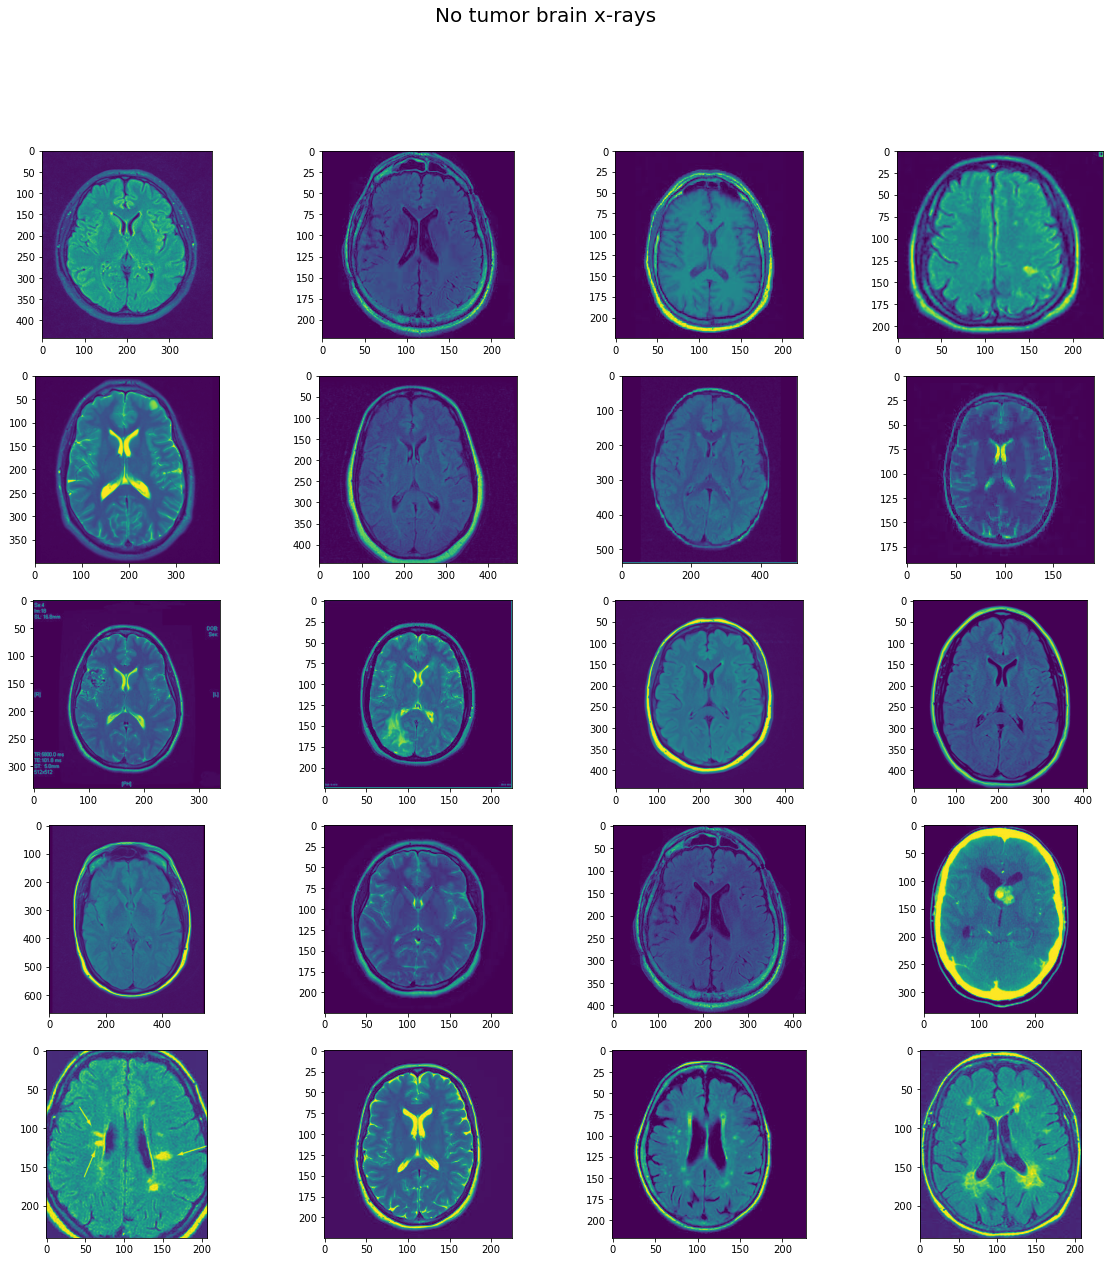

In [4]:
### Let's Plot images belonging to this class (No tumor brain)
w=10
h=10
fig=plt.figure(figsize=(20, 20))
columns = 4
rows = 5
for i in range(1, columns*rows +1):
    img = np.random.randint(10, size=(h,w))
    fig.add_subplot(rows, columns, i)
    fig.suptitle('No tumor brain x-rays', fontsize=20)
    plt.imshow(no_cancer_brain[i])
    
plt.show()

## Import *tumor brain* X-ray images

In [5]:
### tumor brain x-rays
yes_cancer_brain = []
yes_cancer_array = []
yes_cancer_labels = []
#import normal xray image 
for filename in tqdm(glob.glob('../input/brain-mri-images-for-brain-tumor-detection/yes/*')): #assuming gif
    im = cv2.imread(filename)
    gray_scale = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    yes_cancer_brain.append(gray_scale)
    # if you wanna reduce or increase the number of pixels
    img=cv2.resize(gray_scale, (64,64))
    # gray scale converting 
    image = np.asarray(img, dtype=np.float32) / 255
    # array of images with no tumor, in terms of pixels
    yes_cancer_array.append(image)
    # labels
    yes_cancer_labels.append('yes_tumor')

100%|██████████| 155/155 [00:00<00:00, 177.80it/s]


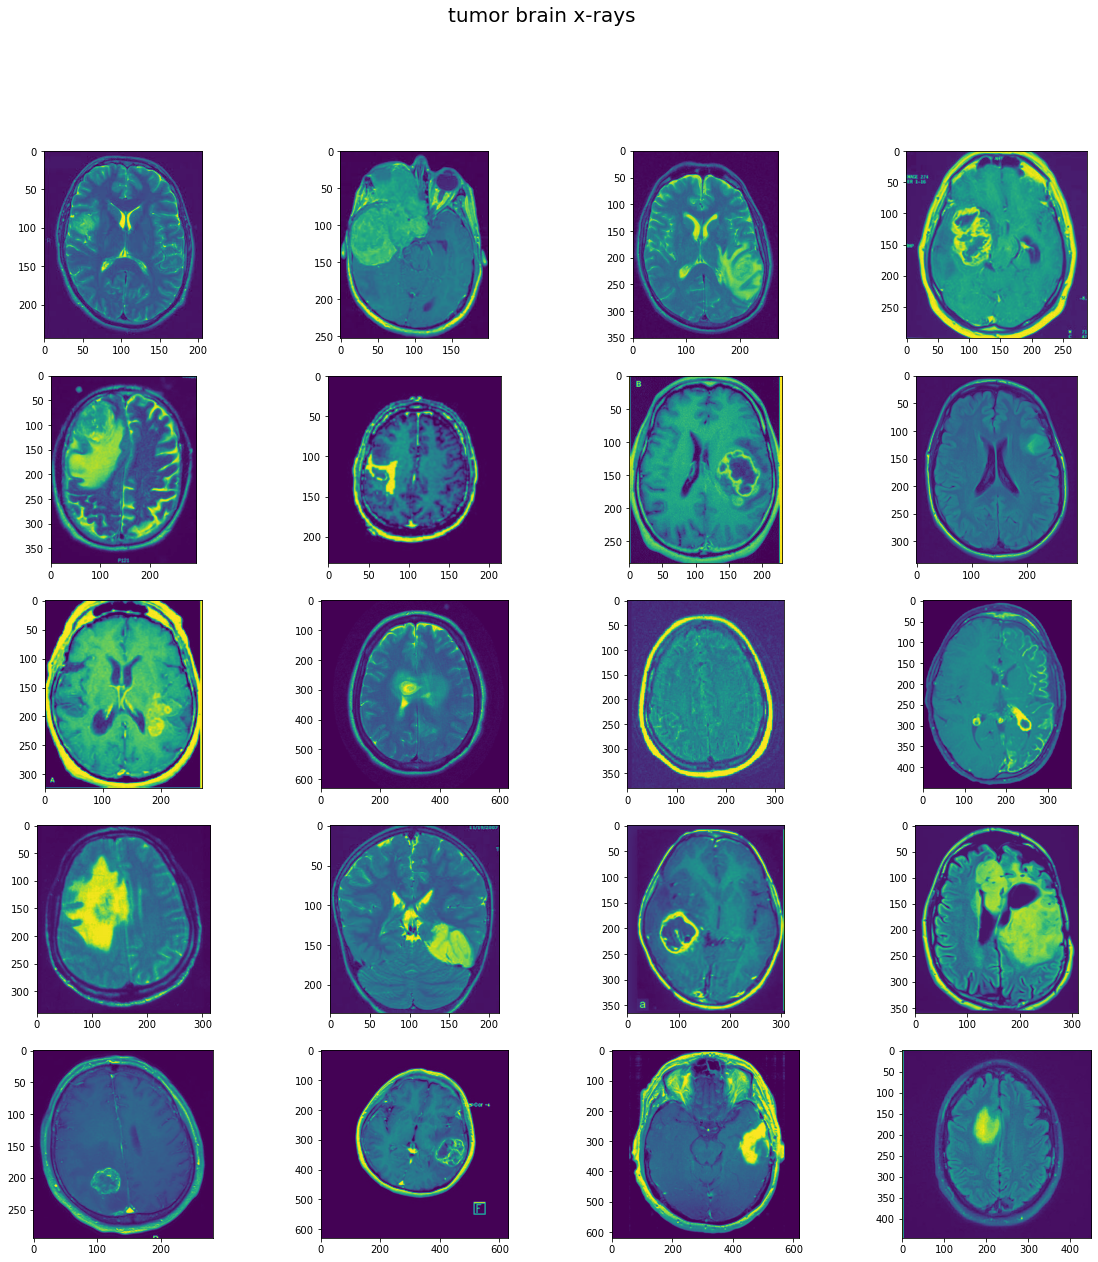

In [6]:
### Let's Plot images belonging to this class (Yes tumor brain)
w=10
h=10
fig=plt.figure(figsize=(20, 20))
columns = 4
rows = 5
for i in range(1, columns*rows +1):
    img = np.random.randint(10, size=(h,w))
    fig.add_subplot(rows, columns, i)
    fig.suptitle('tumor brain x-rays', fontsize=20)
    plt.imshow(yes_cancer_brain[i])
    
plt.show()

## Create Entire Dataset

In [7]:
print('Shape images no cancer: {0} \nSample of images: {1}'
      .format(no_cancer_array[0].shape, len(no_cancer_array)))
print('Shape images yes cancer: {0} \nSample of images: {1}'
      .format(yes_cancer_array[0].shape, len(yes_cancer_array)))
# create the entire dataset as a concatenation from the two list of images
X = np.asarray(no_cancer_array + yes_cancer_array)
print('Total samples in the dataset: %s'%len(X))
labels = no_cancer_labels + yes_cancer_labels
labels = np.asarray(labels)

Shape images no cancer: (64, 64) 
Sample of images: 98
Shape images yes cancer: (64, 64) 
Sample of images: 155
Total samples in the dataset: 253


### Label encoding, convert label "no_tumor" and "yes_tumor" in 0s and 1s 

In [8]:
enc = LabelEncoder()
# Font  encoder
enc_transf=enc.fit_transform(labels)
y=np_utils.to_categorical(enc_transf)


### Split in train and Test

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

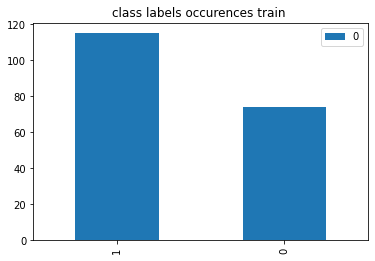

In [10]:
# categorical to labels again to count number of occurences
y_train_labels = np.argmax(y_train, axis=-1)
from collections import Counter

count = Counter(y_train_labels)
df = pd.DataFrame.from_dict(count, orient='index')
df.plot(kind='bar')
plt.title('class labels occurences train ')
plt.show()

 ## **Data Augmentation** due to the small size of the dataset

In [11]:
def plotImages(images_arr, n_images=4):
    fig, axes = plt.subplots(n_images, n_images, figsize=(12,12))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        if img.ndim != 2:
            img = img.reshape( (64,64))
        ax.imshow( img, cmap="Greys_r")
        ax.set_xticks(())
        ax.set_yticks(())
    plt.tight_layout()

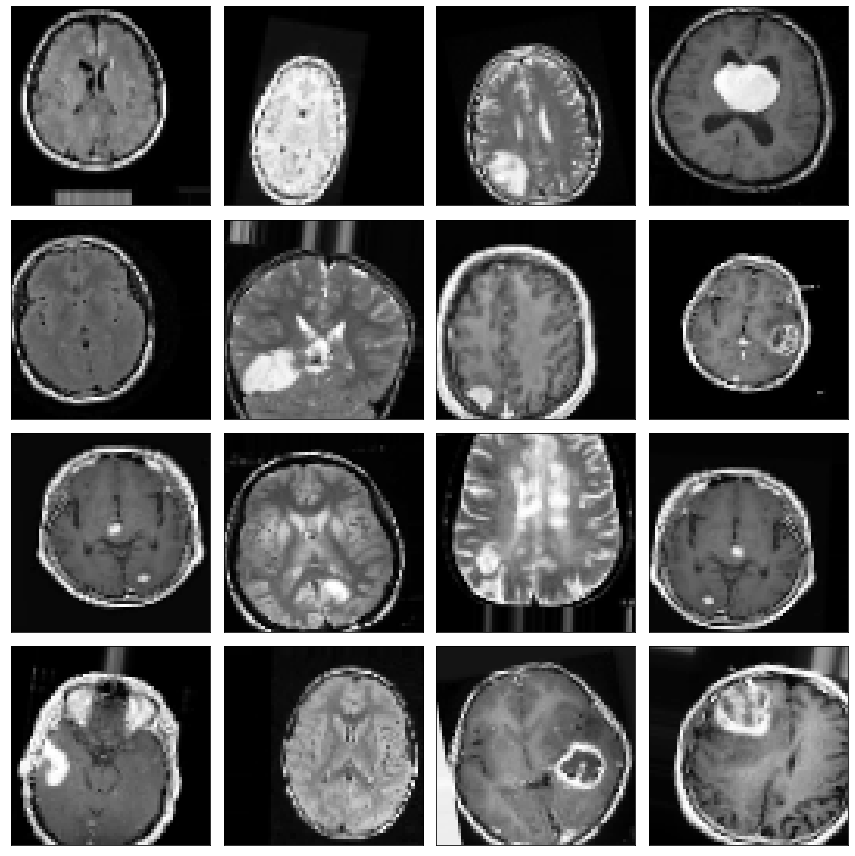

In [12]:
from matplotlib import pyplot

X_train = X_train.reshape((X_train.shape[0], 64, 64, 1))
X_test = X_test.reshape((X_test.shape[0], 64, 64, 1))
# convert from int to float
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
# define data preparation
datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rescale=1./255,
    rotation_range=15,
    width_shift_range=.15,
    height_shift_range=.15,
    horizontal_flip=True)
# fit parameters from data
datagen.fit(X_train)
# visualization of some images out of the preprocessing
augmented_images, _ = next(datagen.flow(X_train, y_train, batch_size=4*4))
plotImages(augmented_images)

## An Example of CNN model

In [18]:
input_shape = X_train[0].shape
batch_size = 64
num_classes = len(y_train[0]) # 2 classes
epochs = 10

print('x_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(32, (5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='binary_crossentropy', 
              optimizer='adam',
              metrics=['accuracy'])
model.summary()
model.fit_generator(datagen.flow(X_train, y_train, batch_size=batch_size),
          steps_per_epoch=  X_train.shape[0]//batch_size,
          epochs=epochs,
          verbose=1)

score = model.evaluate(X_train, y_train, verbose=0)
print('Training loss: {0:.4f}\nTraining accuracy:  {1:.4f}'.format(*score))

x_train shape: (189, 64, 64, 1)
189 train samples
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 62, 62, 32)        320       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 60, 60, 32)        9248      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 26, 26, 32)        25632     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 8, 8, 32)          0         
_________________________________________________________________
flat

In [15]:
score = model.evaluate(X_test, y_test, verbose=0)
print('test loss: {0:.4f}\nTraining accuracy:  {1:.4f}'.format(*score))

test loss: 0.6673
Training accuracy:  0.6250


In [16]:
pred = model.predict(X_test)

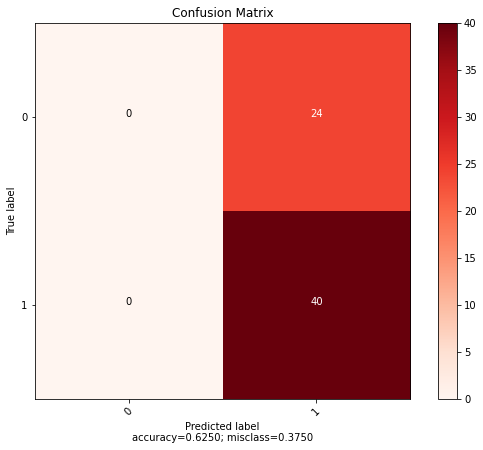

In [19]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.grid(b=False)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()
    
cm = confusion_matrix(np.argmax(y_test, axis = 1),np.argmax(pred, axis = 1))
plot_confusion_matrix(cm = cm,
                      normalize    = False,
                      cmap ='Reds',
                      target_names = ['0','1'],
                      title        = "Confusion Matrix")

As we can see from the results the model performs very bad due to the limited numbers of samples to the train the CNN.

As far as we know from the literature deep learning has a lot of benefits in computer vision and in analyzing images but of course needs a vast amount of data and hw resources (GPU)